# **DEEP LEARNING ALGORITHM(FACE RECOGNITION)**
* Diego Alberto Baños Lopez A01275100


In [1]:
# %pip install opencv-python matplotlib pandas numpy Pillow mtcnn keras scikit-learn
# %pip install tensorflow
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict

# Visualizacion
from PIL import Image

# Face Recognition
from mtcnn.mtcnn import MTCNN

# Bounding Boxes
import matplotlib.patches as patches

# CNN
import keras
from sklearn.model_selection import train_test_split

# Directorios y Archivos
import shutil
from shutil import unpack_archive
from subprocess import check_output
import tensorflow as tf

2023-11-04 16:17:42.352073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
# Creacion de dataframes y designacion de variables

# Ubicación de base
base_path = "./lfw-deepfunneled2/"

# Nuevas ubicaciones de archivos
lfw_allnames = pd.read_csv(base_path + "lfw_allnames.csv")
matchpairsDevTest = pd.read_csv(base_path + "matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv(base_path + "matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv(base_path + "mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv(base_path + "mismatchpairsDevTrain.csv")
pairs = pd.read_csv(base_path + "pairs.csv")

# Datos de pares ordenados:
pairs = pairs.rename(columns={"name": "name1", "Unnamed: 3": "name2"})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2", axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]

# Ubicación de personas
people_path = base_path + "people.csv"
people = pd.read_csv(people_path)

# Eliminación de Valores Nulos
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv(base_path + "peopleDevTest.csv")
peopleDevTrain = pd.read_csv(base_path + "peopleDevTrain.csv")

# **Analisis Exploratorio de los Datos**


Tras haber leido y obtenido los dataframes el siguiente paso es explorar y analizar los datos que en este caso serian los datos del dataset Labelled Faces in the Wild que es un dataset Fotografías de rostros diseñadas para el estudio del problema de reconocimiento de rostros sin restricciones. Esta base de datos fue creada y mantenida por investigadores de la Universidad de Massachusetts, Amherst (referencias específicas se encuentran en la sección de Agradecimientos). Se detectaron y centraron 13,233 imágenes de 5,749 personas mediante el detector de rostros Viola Jones y se recopilaron de la web. 1,680 de las personas retratadas tienen dos o más fotos distintas en el conjunto de datos. La base de datos original contiene cuatro conjuntos diferentes de imágenes de LFW y también tres tipos diferentes de imágenes "alineadas".


Es fundamental comprender la estructura de los datos antes de comenzar a desarrollar el modelo. A continuación, proporciono un resumen de los archivos disponibles en el conjunto de datos LDW, junto con una breve descripción de su contenido:

-   lfw_allnames.csv: Un archivo CSV con dos columnas: "nombre" (una lista de todos los nombres en el conjunto de datos) y "imágenes" (el número de imágenes disponibles para cada nombre).

-   matchpairsDevTest: Una muestra aleatoria de 500 pares de imágenes que pertenecen a la misma persona, con información sobre el nombre y las etiquetas de las imágenes.

-   matchpairsDevTrain: Otra muestra aleatoria de 1100 pares de imágenes que también pertenecen a la misma persona, con detalles sobre el nombre y las etiquetas de las imágenes.

-   mismatchpairsDevTest: Una muestra aleatoria de 500 pares de imágenes que representan a diferentes personas, con información sobre ambos nombres y las etiquetas de las imágenes.

-   mismatchpairsDevTrain: Similar a la muestra anterior, pero con 1100 pares de imágenes que también pertenecen a diferentes personas.

-   pairs.csv: Contiene 6000 pares de imágenes, algunos coinciden y otros no. Los pares coincidentes incluyen un nombre y dos archivos de imágenes, mientras que los pares no coincidentes contienen un nombre para cada imagen.

-   people.csv: Una lista de nombres y recuentos de imágenes, similar a lfw_allnames.csv una vez que se eliminan los valores nulos. No se utilizará en análisis posteriores.

-   peopleDevTest.csv: Destinado a pruebas, contiene información sobre 1711 individuos, incluyendo el nombre de la celebridad y el recuento de imágenes. No se superpone con el conjunto de entrenamiento.

-   peopleDevTrain.csv: Diseñado para entrenamiento, este archivo enumera 4038 individuos con información sobre el nombre de la celebridad y el recuento de imágenes. No hay superposición con el conjunto de pruebas.

En el siguitene codigo se dividira los conjuntos de datos en entrenamiento y prueba dependiendo de cada archivo csv mencionado anteriormente


In [4]:
# Reorganiza el marco de datos para que haya una fila por imagen, relacionada con el archivo jpg correspondiente.
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames["images"])]
image_paths["image_path"] = 1 + image_paths.groupby("name").cumcount()
image_paths["image_path"] = image_paths.image_path.apply(lambda x: "{0:0>4}".format(x))
image_paths["image_path"] = (
    image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
)
image_paths = image_paths.drop("images", axis=1)

# Toma una muestra aleatoria: el 80% de los datos para el conjunto de pruebas.
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index", axis=1)
lfw_test = lfw_test.reset_index().drop("index", axis=1)

# Se verifica que haya una mezcla de individuos conocidos y desconocidos en el conjunto de pruebas.
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

872
822


In [5]:
# Verificar que la resolución de las imagenes sea consistente
widths = []
heights = []
files = image_paths.image_path
base_path = base_path + "lfw-deepfunneled/"
for file in files:
    path = base_path + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({"height": heights, "width": widths}).describe()

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


Una de las desventajas del conjunto de datos LFW es que tiene un desequilibrio significativo de clases como podemos ver a continuacion:


<Axes: >

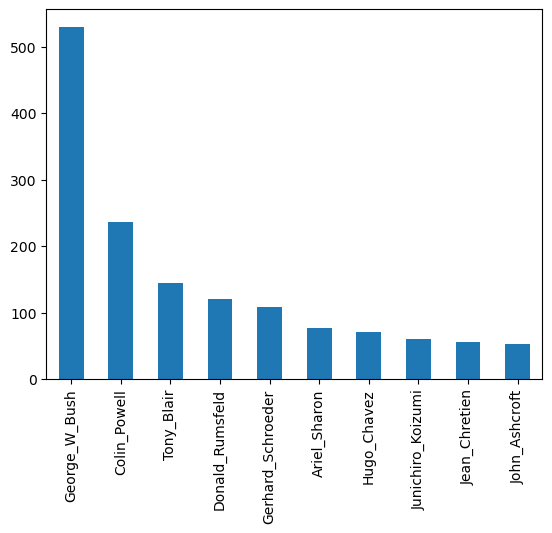

In [6]:
image_paths["name"].value_counts()[:10].plot(kind="bar")

Podemos ver que entre las 10 figuras principales, hay algunas que están muy bien representadas, generalmente figuras políticas y mayormente masculinas. Esto tiene implicaciones importantes para la utilidad de este conjunto de datos en general


In [7]:
ind_counts = image_paths.groupby("name").count().image_path
print(
    str(sum(ind_counts[ind_counts == 1]))
    + " personas las cuales el "
    + str(round(100 * (sum(ind_counts[ind_counts == 1]) / sum(ind_counts))))
    + "% de las personas consideradas en total, solo están representadas por una única imagen en este conjunto de datos."
)

4069 personas las cuales el 31% de las personas consideradas en total, solo están representadas por una única imagen en este conjunto de datos.


Para Finalizar imprimimos una imagen del dataset para verificar que funciono todo correctamente y los directorios para acceder a las imagenes estan bien configurados obteniendo el resultado siguiente


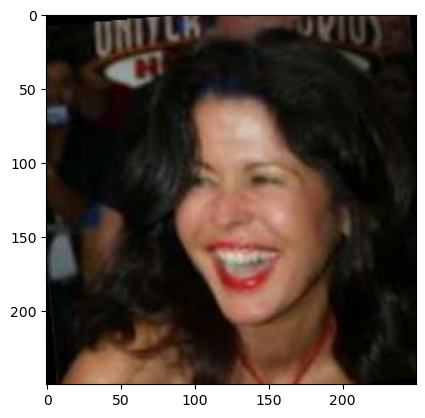

In [8]:
im = Image.open(base_path + str(lfw_train.image_path[0]))
plt.imshow(im)

# **Construccion del Modelo**


In [10]:
not_george = image_paths[image_paths.name != "George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name == "George_W_Bush"], not_george])

In [11]:

bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)

bush_train, bush_val = train_test_split(bush_train, test_size=0.2)

In [12]:
# inicializar red secuencial
from keras.models import Sequential

# incluir capas convolucionales
from keras.layers import Conv2D

# Capas de agrupamiento (Pooling)
from keras.layers import MaxPooling2D

#Aplana las capas en un único vector
from keras.layers import Flatten
from keras.layers import Dense

In [13]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g.
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3), activation="relu"))

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size=(2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units=128, activation="relu"))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units=1, activation="sigmoid"))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

In [14]:
# define a custom function to move images to a new train/test/val directory

top_base = "./"

#Funcion para copiar datos y poder usarlos de manera mas sencilla
def directory_mover(data, dir_name):
    co = 0
    for image in data.image_path:
        

        if not os.path.exists(os.path.join(dir_name)):
            shutil.os.mkdir(os.path.join(top_base, dir_name))
        data_type = data[data["image_path"] == image]["name"]
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join(top_base, dir_name, data_type)):
            shutil.os.mkdir(os.path.join(top_base, dir_name, data_type))
        path_from = os.path.join(base_path, image)
        path_to = os.path.join(top_base, dir_name, data_type)
        shutil.copy(path_from, path_to)
        co += 1

    print("Se movieron {} imagenes a la carpeta {}.".format(co, dir_name))

In [15]:
# move images:
directory_mover(bush_train, "Bush_train/")
directory_mover(bush_val, "Bush_val/")
directory_mover(bush_test, "Bush_test/")
import keras.utils as image

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
Bush_training_set = train_datagen.flow_from_directory(
    top_base + "/Bush_train/",
    target_size=(250, 250),
    batch_size=32,
    class_mode="binary",
)
Bush_val_set = test_datagen.flow_from_directory(
    top_base + "/Bush_val/",
    target_size=(250, 250),
    batch_size=32,
    class_mode="binary",
)
Bush_test_set = test_datagen.flow_from_directory(
    top_base + "/Bush_test/",
    target_size=(250, 250),
    batch_size=32,
    class_mode="binary",
)

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [17]:
Bush_history = Bush_classifier.fit(
    Bush_training_set,
    # set steps per epoch equal to the number of training images
    steps_per_epoch=len(Bush_training_set),
    # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
    epochs=8,
    validation_data=Bush_val_set,
    validation_steps=len(Bush_val_set),
)

Epoch 1/8
22/22 [==============================] - 15s 673ms/step - loss: 9.4118 - accuracy: 0.5162 - val_loss: 0.9077 - val_accuracy: 0.6118
Epoch 2/8
22/22 [==============================] - 14s 616ms/step - loss: 0.8801 - accuracy: 0.5900 - val_loss: 0.6704 - val_accuracy: 0.6000
Epoch 3/8
22/22 [==============================] - 14s 639ms/step - loss: 0.6406 - accuracy: 0.6504 - val_loss: 0.6508 - val_accuracy: 0.6294
Epoch 4/8
22/22 [==============================] - 15s 649ms/step - loss: 0.6300 - accuracy: 0.6534 - val_loss: 0.6210 - val_accuracy: 0.6765
Epoch 5/8
22/22 [==============================] - 15s 660ms/step - loss: 0.5662 - accuracy: 0.7021 - val_loss: 0.6004 - val_accuracy: 0.7059
Epoch 6/8
22/22 [==============================] - 14s 635ms/step - loss: 0.5510 - accuracy: 0.7006 - val_loss: 0.5140 - val_accuracy: 0.7941
Epoch 7/8
22/22 [==============================] - 14s 649ms/step - loss: 0.4721 - accuracy: 0.7847 - val_loss: 0.4786 - val_accuracy: 0.7706
Epoch 

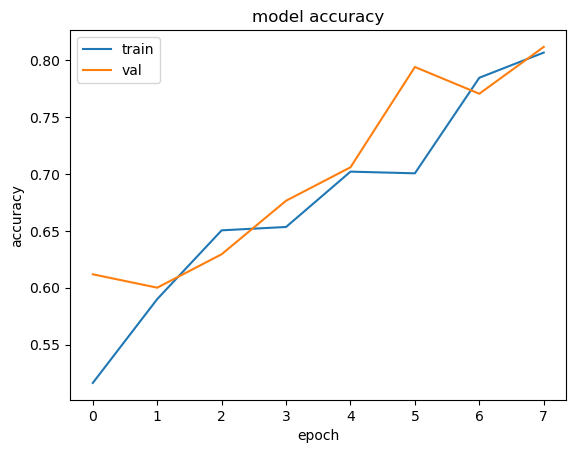

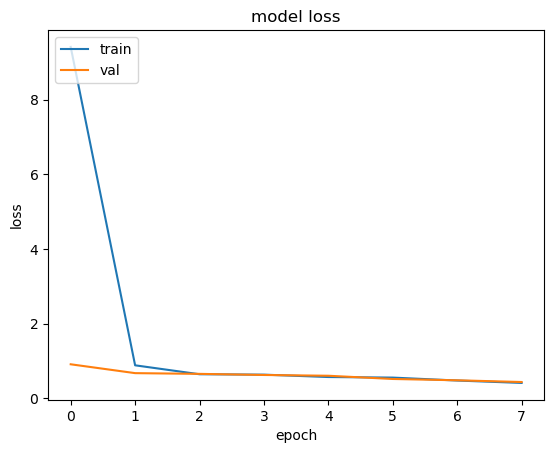

In [18]:
plt.plot(Bush_history.history["accuracy"])
plt.plot(Bush_history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

plt.plot(Bush_history.history["loss"])
plt.plot(Bush_history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [19]:
from tensorflow.keras.preprocessing import image


# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name, classifier, binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size=(250, 250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)
        if binary is True:
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return predictions

In [20]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []
# collect all file names
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# extract unique names, in order
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [21]:
# Compute predictions
Bush_predictions_0 = predictions(
    top_base + "Bush_test/" + Bush_test_name_order[0] + "/",
    Bush_classifier,
    binary=True,
)
Bush_predictions_1 = predictions(
    top_base + "/Bush_test/" + Bush_test_name_order[1] + "/",
    Bush_classifier,
    binary=True,
)

# Compare predictions to actual classes
Bush_predictions_frame = pd.DataFrame(
    list(
        zip(
            Bush_predictions_0 + Bush_predictions_1,
            [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1),
        )
    ),
    columns=["Predictions", "Actual"],
)

1/1 [==============================] - 0s 74ms/step


In [22]:
# función para encontrar la precisión y el recall de las predicciones,
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        # Verdaderos positivos: Casos donde la predicción y el valor actual son i
        tp = predictions_frame[
            np.logical_and(
                predictions_frame["Actual"] == i, predictions_frame["Predictions"] == i
            )
        ].shape[0]
        # Verdaderos negativos: Casos donde ni la predicción ni el valor actual son i
        tn = predictions_frame[
            np.logical_and(
                predictions_frame["Actual"] != i, predictions_frame["Predictions"] != i
            )
        ].shape[0]
        # Falsos positivos: Casos donde la predicción es i pero el valor actual no
        fp = predictions_frame[
            np.logical_and(
                predictions_frame["Actual"] != i, predictions_frame["Predictions"] == i
            )
        ].shape[0]
        # Falsos negativos: Casos donde el valor actual es i pero la predicción no
        fn = predictions_frame[
            np.logical_and(
                predictions_frame["Actual"] == i, predictions_frame["Predictions"] != i
            )
        ].shape[0]
        # Total de predicciones
        total_preds = predictions_frame.shape[0]

        # Verificación para evitar la división por cero en la precisión
        if (tp + fp) > 0:
            precision.append(tp / (tp + fp))
        else:
            precision.append(
                0
            )  # o np.nan o cualquier otro valor que indique una precisión indefinida

        # Calcular la precisión
        accuracy.append((tp + tn) / total_preds)

        # Verificación para evitar la división por cero en el recall
        if (tp + fn) > 0:
            recall.append(tp / (tp + fn))
        else:
            recall.append(0)  # o np.nan o cualquier otro valor que indique un recall indefinido

    return (accuracy, precision, recall)

Bush_predictions_frame

,Predictions,Actual
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,1.0,0
...,...,...
207,0.0,1
208,1.0,1
209,1.0,1
210,1.0,1


In [23]:
Bush_accuracy = prec_acc(Bush_predictions_frame)
print("Accuracy:" + str(Bush_accuracy[0]))
print("Precision:" + str(Bush_accuracy[1]))
print("Recall:" + str(Bush_accuracy[2]))
print(Bush_test_name_order)

Accuracy:[0.7405660377358491, 0.7311320754716981, 1.0, 0.9905660377358491, 0.9952830188679245, 0.9952830188679245]
Precision:[0.647887323943662, 0.953125, 0, 0.0, 0.0, 0.0]
Recall:[0.9484536082474226, 0.5304347826086957, 0, 0, 0, 0]
['George_W_Bush', 'not_George']


In [24]:
if "Bush_train" in os.listdir("./"):
    shutil.rmtree("./Bush_train")
if "Bush_val" in os.listdir("./"):
    shutil.rmtree("./Bush_val")
if "Bush_test" in os.listdir("./"):
    shutil.rmtree("./Bush_test")

In [25]:
image_paths["name"].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

In [26]:
#Creacion del dataset
multi_data = pd.concat(
    [
        image_paths[image_paths.name == "George_W_Bush"].sample(75),
        image_paths[image_paths.name == "Colin_Powell"].sample(75),
        image_paths[image_paths.name == "Tony_Blair"].sample(75),
        image_paths[image_paths.name == "Donald_Rumsfeld"].sample(75),
        image_paths[image_paths.name == "Gerhard_Schroeder"].sample(75),
        image_paths[image_paths.name == "Ariel_Sharon"].sample(75),
    ]
)

In [27]:
# retener datos finales de prueba
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# dividir en datos de validación
multi_train, multi_val = train_test_split(multi_train, test_size=0.2)

# Misma configuración del modelo que antes
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3), activation="relu"))
multi_classifier.add(MaxPooling2D(pool_size=(2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units=128, activation="relu"))

# Como estamos entrenando en varias clases, necesitamos varias unidades de clasificación (una para cada clase). También usamos una
# función de activación softmax
multi_classifier.add(Dense(units=6, activation="softmax"))
# Cambiamos la función de pérdida a categorical_crossentropy
multi_classifier.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

# mover imágenes a directorios separados
directory_mover(multi_train, "train_multi/")
directory_mover(multi_val, "val_multi/")
directory_mover(multi_test, "test_multi/")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
multi_training_set = train_datagen.flow_from_directory(
    top_base + "/train_multi/",
    target_size=(250, 250),
    batch_size=32,
    class_mode="categorical",
)
multi_val_set = test_datagen.flow_from_directory(
    top_base + "/val_multi/",
    target_size=(250, 250),
    batch_size=32,
    class_mode="categorical",
)
multi_test_set = test_datagen.flow_from_directory(
    top_base + "/test_multi/",
    target_size=(250, 250),
    batch_size=32,
    class_mode="categorical",
)


multi_history = multi_classifier.fit_generator(
    multi_training_set,
    # establecer pasos por época igual al número de imágenes de entrenamiento
    steps_per_epoch=len(multi_training_set),
    # como los datos son menores, podemos ejecutar más epochs
    epochs=14,
    validation_data=multi_val_set,
    validation_steps=len(multi_val_set),
)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 702 images belonging to 6 classes.
Found 482 images belonging to 6 classes.
Found 509 images belonging to 6 classes.


/tmp/ipykernel_24454/2554481403.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  multi_history = multi_classifier.fit_generator(


Epoch 1/14
22/22 [==============================] - 19s 822ms/step - loss: 12.7434 - accuracy: 0.2308 - val_loss: 1.9587 - val_accuracy: 0.2676
Epoch 2/14
22/22 [==============================] - 16s 725ms/step - loss: 1.6952 - accuracy: 0.3262 - val_loss: 1.6323 - val_accuracy: 0.3589
Epoch 3/14
22/22 [==============================] - 16s 719ms/step - loss: 1.6166 - accuracy: 0.3561 - val_loss: 1.5768 - val_accuracy: 0.3568
Epoch 4/14
22/22 [==============================] - 16s 725ms/step - loss: 1.5141 - accuracy: 0.4088 - val_loss: 1.4528 - val_accuracy: 0.4274
Epoch 5/14
22/22 [==============================] - 17s 761ms/step - loss: 1.3955 - accuracy: 0.4615 - val_loss: 1.2585 - val_accuracy: 0.5145
Epoch 6/14
22/22 [==============================] - 17s 760ms/step - loss: 1.2477 - accuracy: 0.5342 - val_loss: 1.0088 - val_accuracy: 0.6390
Epoch 7/14
22/22 [==============================] - 19s 846ms/step - loss: 1.0872 - accuracy: 0.6011 - val_loss: 0.9196 - val_accuracy: 0.668

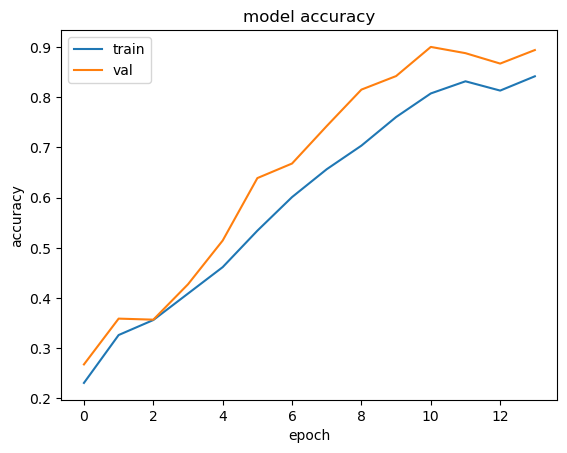

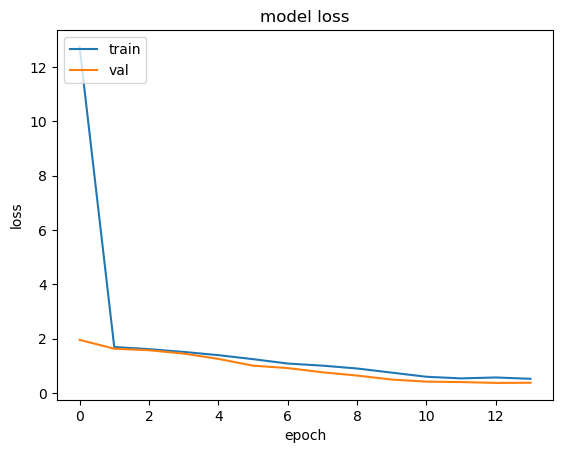

In [28]:
# Graficos para comparar resultados del modelo
plt.plot(multi_history.history["accuracy"])
plt.plot(multi_history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

plt.plot(multi_history.history["loss"])
plt.plot(multi_history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [29]:
# las clases se pasan a través del algoritmo en un orden aleatorio - queremos recuperar el orden de las clases
multi_test_names = []
# recopilar todos los nombres de archivo
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
# extraer nombres únicos, en orden
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

In [30]:
multi_predictions_0 = predictions(
    top_base + "/test_multi/" + multi_test_name_order[0] + "/",
    multi_classifier,
    binary=False,
)
multi_predictions_1 = predictions(
    top_base + "/test_multi/" + multi_test_name_order[1] + "/",
    multi_classifier,
    binary=False,
)
multi_predictions_2 = predictions(
    top_base + "/test_multi/" + multi_test_name_order[2] + "/",
    multi_classifier,
    binary=False,
)
multi_predictions_3 = predictions(
    top_base + "/test_multi/" + multi_test_name_order[3] + "/",
    multi_classifier,
    binary=False,
)
multi_predictions_4 = predictions(
    top_base + "/test_multi/" + multi_test_name_order[4] + "/",
    multi_classifier,
    binary=False,
)
multi_predictions_5 = predictions(
    top_base + "/test_multi/" + multi_test_name_order[5] + "/",
    multi_classifier,
    binary=False,
)

1/1 [==============================] - 0s 24ms/step


In [31]:
multi_predictions_frame = pd.DataFrame(
    list(
        zip(
            multi_predictions_0
            + multi_predictions_1
            + multi_predictions_2
            + multi_predictions_3
            + multi_predictions_4
            + multi_predictions_5,
            [0] * len(multi_predictions_0)
            + [1] * len(multi_predictions_1)
            + [2] * len(multi_predictions_2)
            + [3] * len(multi_predictions_3)
            + [4] * len(multi_predictions_4)
            + [5] * len(multi_predictions_5),
        )
    ),
    columns=["Predictions", "Actual"],
)

In [32]:
multi_accuracy = prec_acc(multi_predictions_frame)
print("Accuracy:" + str(multi_accuracy[0]))
print("Precision:" + str(multi_accuracy[1]))
print("Recall:" + str(multi_accuracy[2]))
print(multi_test_name_order)

Accuracy:[0.9705304518664047, 0.93713163064833, 0.8762278978388998, 0.9233791748526523, 0.962671905697446, 0.9449901768172888]
Precision:[0.868421052631579, 1.0, 0.5673758865248227, 0.9692307692307692, 0.9384615384615385, 0.7857142857142857]
Recall:[0.9295774647887324, 0.6666666666666666, 0.975609756097561, 0.63, 0.8026315789473685, 0.9166666666666666]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


In [33]:
# Guardar el modelo en un archivo
model_path = 'A01275100_modelo.h5' 
multi_classifier.save(model_path)